# Model Export Example

This notebook provides an end-to-end example on how to train and export a PyTorch classification model to a format accepted by uniVision Module Image ONNX. This will allow you to deploy your models on the Wenglor's B60 Smart Camera and MVC Machine Vision Controller.

DISCLAIMER: Focus of this notebook is to provide an example for the export and quantization. The training code is provided purely for illustration and not meant to provide a production-grade model. You will want to optimize the training pipeline and add more images. Depending on your situation, you can start from one of the following steps: 
1. Train PyTorch model.
    * If you don't have a trained model, start here. 
2. Export PyTorch model to ONNX.
    * If you already have a trained PyTorch model, start here.
3. Quantize ONNX model (optional for B60, not recommemded for MVC).
    * If you have a trained ONNX model and it supports quantization, e.g. the model is in the list of quantization supported models (see below), start here. For this step, you will also need to provide a dataset that your model had been trained on. This dataset will be used for a calibration step during model quantization. 
4. Export ONNX model.
    * If your ONNX model does not support quantization or you cannot provide a calibration dataset, begin here. Similarly, if you plan to deploy your unquantized model on the MVC Machine Vision Controller, this is also the right starting point.  
  
The models below have been tested and are known to run successfully:
* `torchvision.models.quantization.resnet18`
* `torchvision.models.quantization.resnet50`

Other models may also be supported either through execution on the CPU or even hardware-accelerated. Please report your findings and we will update this list.

**What is quantization and why do we need it?**

Quantization is a technique used to make machine learning models run faster and more efficiently, especially on smaller devices with limited resources, like smartphones or smart cameras. By reducing the precision of the numbers the model uses, it can significantly decrease the amount of memory and computing power required, without losing too much accuracy. For example, our benchmark results show that a quantized ResNet50 model running on a B60 camera achieves an inference speed of 50 milliseconds, which is 8.4 times faster than the unquantized version (420 milliseconds). 

## 1. Train PyTorch model 

In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import uuid
from PIL import Image
from sklearn.model_selection import train_test_split
from torcheval.metrics import MulticlassAccuracy
from torchvision.transforms import v2 as T
from utils.heatmap import get_heatmap_feature_layer
from utils.image import read_image_file

In [2]:
IMAGE_SIZE = (224, 224)
EPOCHS = 50
BATCH_SIZE = 32
NUM_WORKERS = 4

DATA_ROOT = "data"
IMAGE_DIR = DATA_ROOT + "/images"
MODEL_DIR = DATA_ROOT + "/model"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 1.1 Get dataframe

For this example, we will use a small rock-paper-scissors dataset consisting of 200 images across 3 classes.

In [3]:
image_paths = sorted(glob.glob(IMAGE_DIR + "/**/*.bmp"))
len(image_paths), image_paths[:2]

(200,
 ['data/images/paper/114616939837.bmp', 'data/images/paper/114616965320.bmp'])

In [4]:
classes = sorted(set([image_path.split("/")[-2] for image_path in image_paths]))
classes

['paper', 'rock', 'scissors']

In [5]:
df = pd.DataFrame({"image_path": image_paths})

df["target"] = df.image_path.apply(lambda x: x.split("/")[-2])
df["target"] = df.target.map({v: k for k, v in enumerate(classes)})

print(df.shape)
df.head(2)

(200, 2)


,image_path,target
0,data/images/paper/114616939837.bmp,0
1,data/images/paper/114616965320.bmp,0


In [6]:
train, valid = train_test_split(df, test_size=0.1, random_state=0, stratify=df.target)
train.shape, valid.shape

((180, 2), (20, 2))

### 1.2 Create dataset

Define image preprocessing and augmentations. For more information on image preprocessing and normalization, please see Export ONNX model. For this example, we will rescale input values to the `[0, 1]` range. For image augmentations, we use random changes in brightness and contrast, along with image rotating and scaling. Depending on your case, different preprocessing and augmentations could be applied. 

In [7]:
train_transform = T.Compose(
    [
        T.Resize(IMAGE_SIZE),
        T.ColorJitter(brightness=0.5, contrast=0.5),
        T.RandomAffine(degrees=(-180, 180), scale=(0.8, 1.2)),
        T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]),
    ]
)
valid_transform = T.Compose(
    [
        T.Resize(IMAGE_SIZE),
        T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]),
    ]
)

In [8]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image, target = (
            read_image_file(self.df.image_path.iloc[index]),
            self.df.target.iloc[index],
        )

        image = (
            cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            if len(image.shape) == 2 or image.shape[2] == 1
            else image
        )
        
        return self.transform(Image.fromarray(image)), target

In [9]:
train_dataset = ImageDataset(train, train_transform)
valid_dataset = ImageDataset(valid, valid_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
)

### 1.3 Plot images

Check that the selected image preprocessing and augmentations work correctly.  

In [10]:
def plot_images(batch, rows, columns):

    plt.figure(
        figsize=(IMAGE_SIZE[1] // 12, IMAGE_SIZE[0] // 12 * rows // columns),
        frameon=False,
    )

    for index in range(rows * columns):

        plt.subplot(rows, columns, index + 1)
        plt.axis("off")
        plt.imshow(batch[0][index].numpy().transpose(1, 2, 0), aspect="auto")
        plt.text(
            IMAGE_SIZE[1] // 2,
            IMAGE_SIZE[0] - 10,
            classes[batch[1][index].numpy()],
            size=10,
            ha="center",
            color="k",
            bbox=dict(boxstyle="round, pad=0", facecolor="w", edgecolor="w"),
        )
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

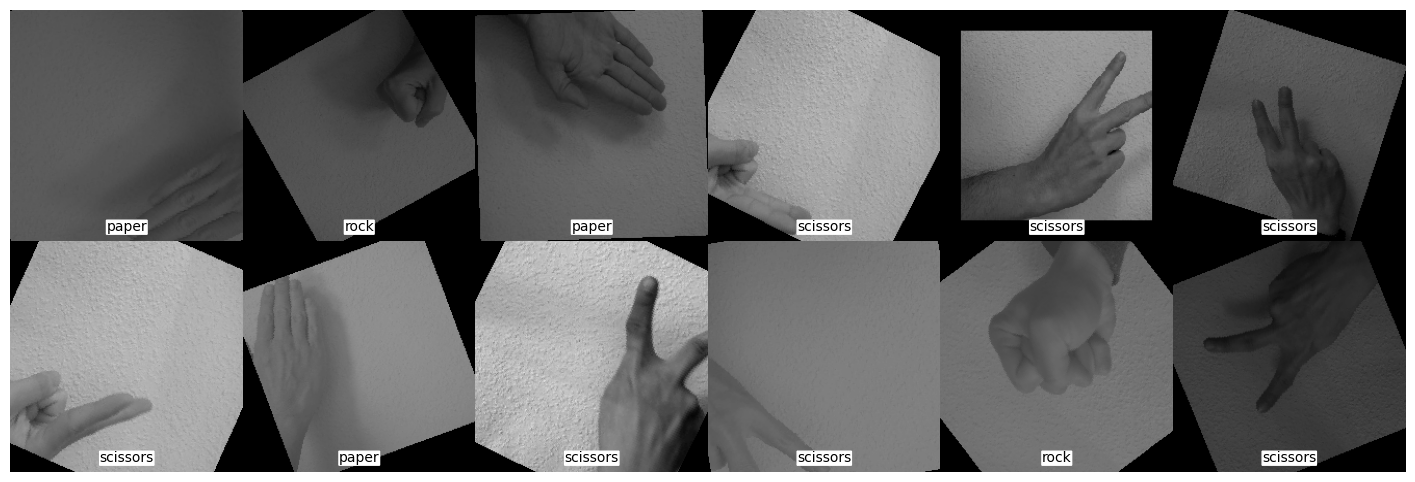

In [11]:
plot_images(next(iter(train_dataloader)), rows=2, columns=6)

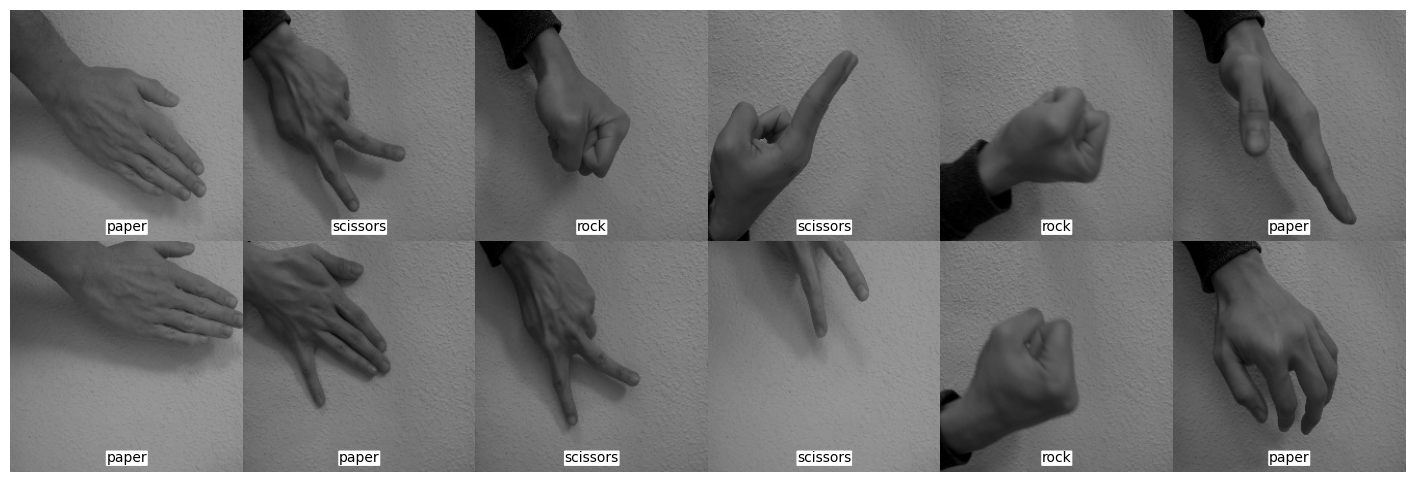

In [12]:
plot_images(next(iter(valid_dataloader)), rows=2, columns=6)

### 1.4 Train model

If you're looking for a model that supports quantization, see the list of quantization supported models at the beginning of the notebook. Otherwise, any model that supports ONNX export with the opset version 11 can be used. 

In [13]:
class Model(torch.nn.Module):
    def __init__(self, classes, return_logits=True):
        super(Model, self).__init__()

        self.classes = classes
        self.return_logits = return_logits
        self.backbone = torchvision.models.quantization.resnet18(weights="DEFAULT")
        self.backbone.fc = torch.nn.Linear(
            self.backbone.fc.in_features, out_features=len(self.classes)
        )
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        if self.return_logits:
            return x
        return self.softmax(x)

In [14]:
def train_model(model, dataloaders):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(dataloaders["train"]),
        epochs=EPOCHS,
    )
    metric = MulticlassAccuracy(average="macro", num_classes=len(classes))

    for epoch in range(EPOCHS):

        epoch_log = [f"epoch {epoch+1:04d}/{EPOCHS:04d}"]
        for phase in ["train", "valid"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0
            metric.reset()

            for inputs, target in dataloaders[phase]:
                inputs = inputs.to(device)
                target = target.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    output = model(inputs)
                    loss = criterion(output, target)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                metric.update(torch.argmax(output, 1), target)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_metric = metric.compute()

            epoch_log.append(
                f"{phase}_loss: {epoch_loss:.4f} {phase}_balanced_accuracy: {epoch_metric:.4f}"
            )
        epoch_log.append(f"lr: {scheduler.get_last_lr()[0]:.6f}")
        print(" ".join(epoch_log))

In [15]:
dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
}

model = Model(classes, return_logits=True)
model.to(device)

train_model(model, dataloaders)
torch.save(model.state_dict(), MODEL_DIR + "/weights.pth")

/usr/local/lib/python3.11/dist-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


epoch 0001/0005 train_loss: 1.1540 train_balanced_accuracy: 0.4044 valid_loss: 0.9516 valid_balanced_accuracy: 0.4815 lr: 0.000859
epoch 0002/0005 train_loss: 0.6176 train_balanced_accuracy: 0.7460 valid_loss: 0.8136 valid_balanced_accuracy: 0.7222 lr: 0.000913
epoch 0003/0005 train_loss: 0.7711 train_balanced_accuracy: 0.7278 valid_loss: 1.9727 valid_balanced_accuracy: 0.6806 lr: 0.000537
epoch 0004/0005 train_loss: 0.5490 train_balanced_accuracy: 0.7659 valid_loss: 0.8535 valid_balanced_accuracy: 0.8333 lr: 0.000133
epoch 0005/0005 train_loss: 0.4560 train_balanced_accuracy: 0.8166 valid_loss: 0.1755 valid_balanced_accuracy: 0.9213 lr: 0.000006


In [16]:
# Reinitialize the model with a softmax layer to return probabilities.
model = Model(classes, return_logits=False)
model.to(device)
model.eval()

model.load_state_dict(torch.load(MODEL_DIR + "/weights.pth"))

<All keys matched successfully>

## 2. Export PyTorch model to ONNX

If you already have a trained PyTorch model, start here. Please note that in order to run a PyTorch model on Wenglor devices, it should support ONNX export with a specific opset version. Please also note that if you want to quantize your model further, it has to be in the list of quantization supported models at the beginning of the notebook.

In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
FP32_ONNX_MODEL_PATH = MODEL_DIR + "/fp32_model.onnx"

In [19]:
# Define your variables and your PyTorch model here.
# IMAGE_SIZE = ...

# model = ...

In [20]:
torch.onnx.export(
    model,
    torch.randn((1, 3, *IMAGE_SIZE)).to(device),
    FP32_ONNX_MODEL_PATH,
    export_params=True,
    verbose=False,
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
)

## 3. Quantize ONNX model (optional for B60, not recommemded for MVC)

If you already have a trained ONNX model that supports quantization, start here. This step also requires you to define your training and validation datasets and dataloaders. Please note that if your model has a softmax layer it will be excluded from quantization.

In [21]:
import cv2
import numpy as np
from utils.quantization import quantize_onnx_model

In [22]:
# Define your variables here.
# IMAGE_SIZE = ...
# FP32_ONNX_MODEL_PATH = ...

# train_dataloader = ...
# valid_dataloader = ... (optional)

In [23]:
INT8_ONNX_MODEL_PATH = MODEL_DIR + "/int8_model.onnx"

In [24]:
quantize_onnx_model(FP32_ONNX_MODEL_PATH, INT8_ONNX_MODEL_PATH, train_dataset)

### 3.1 Compare FP32 and INT8 models (optional)

If you have a validation dataset, you can measure the performance of your model before and after quantization.  

In [25]:
dnn = cv2.dnn.readNetFromONNX(FP32_ONNX_MODEL_PATH)
dnn.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
dnn.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

y_true, y_pred = [], []
for inputs, target in valid_dataloader:
    dnn.setInput(inputs.numpy())
    output = dnn.forward()

    y_true.append(target)
    y_pred.append(output)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

In [26]:
f"Model accuracy before quantization: {sum(y_true == np.argmax(y_pred, axis=1)) / len(y_true):.02%}"

'Model accuracy before quantization: 90.00%'

In [27]:
dnn = cv2.dnn.readNetFromONNX(INT8_ONNX_MODEL_PATH)
dnn.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
dnn.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

y_true, y_pred = [], []
for inputs, target in valid_dataloader:
    dnn.setInput(inputs.numpy())
    output = dnn.forward()

    y_true.append(target)
    y_pred.append(output)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

In [28]:
f"Model accuracy after quantization: {sum(y_true == np.argmax(y_pred, axis=1)) / len(y_true):.02%}"

'Model accuracy after quantization: 90.00%'

## 4. Export ONNX model

If your ONNX model cannot be quantized but was exported to ONNX with the supported opset version, it can still be run on a B60 camera or an MVC Machine Vision Controller using CPU. If your model, on the other hand, supports quantization, it could be run on a B60 camera using NPU.

### 4.1 YAML format

During model export, a metadata `.yaml` file is generated, which contains all the necessary information about the model, such as the input size, class names, etc. Please review the example metadata file and its description below. 

#### 4.1.1 `.yaml` metadata file example

```
%YAML 1.2
---
metadata_version: '1.0.0'
model_uuid: '06f8a78c-e45a-4a86-a034-9deff53d8832'
creation_time: '2024-12-03T15:35:42'
quantization: INT8
heatmap_feature_layer: '/backbone/layer4/layer4.1/Add_quant'
dataset_color_mode: MONOCHROME
input:
  width: 224
  height: 224
  channels: 3
  unit_scaling: true
  standardization_std: # optional
  - 0.485
  - 0.456
  - 0.406
  standardization_mean: # optional
  - 0.229
  - 0.224
  - 0.225
  channel_order: NCHW
  color_space: RGB
outputs:
  - type: MULTI_CLASS_CLASSIFICATION
    classes:
      - uuid: '83274b42-8050-41cf-a5a3-9e54418b4772'
        name: 'paper'
      - uuid: '5f740e12-9744-4b21-9f21-d428b5ad24eb'
        name: 'rock'
      - uuid: '93766c15-3923-4203-be41-2f7a568b006e'
        name: 'scissors'
```

#### 4.1.2 `.yaml` metadata file description

| Name | Type | Required | Description |
|:-:|:-:|:-:|:-|
| **Root node** | | | |
| metadata_version | str | yes | The version in SemVer format. |
| model_uuid | str | no | A unique model identifier to find it in the logs of a training service. Must be a UUID version 4 (randomly generated), RFC 4122. If not provided, a `model_uuid` will be automatically generated. |
| model_name | str | no | A name for the model, which can be used as a human-friendly identifier. If the `model_name` field is missing or null, it is treated as an empty string. |
| creation_time | str | yes | The time when a uniVision ONNX model is exported. Time uses ISO 8601 format without time zones (the time zone is UTC by convention) and without microseconds e.g. '2023-11-01T18:19:30'. |
| quantization | str | no | Quantization of weights (if any):<ul><li>`null` (default, no quantization is applied, weights are in `FLOAT32` format)</li><li>`INT8` (only such models can run on an NPU)</li> |
| heatmap_feature_layer | str | no | The name of the ONNX layer, which output is used to produce a saliency map. For example `/backbone/layer4/layer4.1/Add_quant` or `/backbone/layer4/layer4.1/Add`. |
| dataset_color_mode | str | yes | One of:<ul><li>`MONOCHROME`</li><li>`COLOR`</ul>A property of dataset on which a model was trained, to avoid train/test distribution shift the univision Module Image ONNX must be connected to the data source of the same format.<br>Valid combinations of `dataset_color_mode` and `input:color_space`:<ul><li>`dataset_color_mode=MONOCHROME` and `input:color_space=GRAYSCALE`</li><li>`dataset_color_mode=MONOCHROME` and `input:color_space=RGB/BGR` when data is copied into 3 channels of model input</li><li>`dataset_color_mode=COLOR` and `input:color_space=RGB/BGR`</ul>Invalid combinatrions:<ul><li>`dataset_color_mode=COLOR` and `input:color_space=GRAYSCALE`</li></ul>Export your model with:<ul><li>`COLOR` if a training dataset contains color images</li><li>`MONOCHROME` otherwise</li></ul> |
| **Input section** | | | |
| width | int | yes | Image width. |
| height | int | yes | Image height. |
| channels | int | yes | The number of channels of the ONNX file. |
| unit_scaling | bool | no | Specifies if the pixel intensities has to be rescaled from 0..255 to 0.0..1.0 range by dividing them by 255. By default it is `false`. Unit scaling is performed before standardization. This key can be omitted, its default value must be used in this case. |
| standardization_std | seq[float] | no | Standard deviation values per channel as defined by `channel_order` used to divide input values, the number of values depends on channels. If `null` (default), no division is performed. This key can be omitted, its default value must be used in this case. |
| standardization_mean | seq[float] | no | Mean value per channel as defined by `channel_order` used to subtract from input values, the number of values depends on channels. If `null` (default), no subtraction is performed. Standardization runs after unit scaling. During standardization mean subtraction is performed before division by std. This key can be omitted, its default value must be used in this case. |
| channel_order | str | yes | Format of the model input:<ul><li>`NHWC` - batch size, height, width, channels</li><li>`NCHW` - batch size,  channels, height, width</li></ul>|
| color_space | str | yes | Image color space as expected by a model. uniVision Module Image ONNX expects colored inputs in case of `RGB` / `BGR` (and reorders channels according to the needs of the ONNX model if this is required) and grayscale inputs in case of `GRAYSCALE`:<ul><li>`RGB`</li><li>`BGR`</li><li>`GRAYSCALE`</li></ul>Allowed combinations of channels and `color_space`:<ul><li>`color_space=GRAYSCALE channels=1`</li><li>`color_space=RGB/BGR channels=3`</li></ul>Disallowed combinations of channels and color_space:<ul><li>`color_space=GRAYSCALE channels=3`</li><li>`color_space=RGB/BGR channels=1`</li></ul> |
| **Outputs section** | | | |
| type | str | yes | At this moment the only supported type is `MULTI_CLASS_CLASSIFICATION`. |
| classes | seq[str] | yes | The value is a list of strings. The length of the list is the number of classes and it must match the corresponding output dimension. The class names should be listed in the same order as their corresponding indices in the ONNX output. |

### 4.2 Heatmap feature layer (optional)

Saliency map generation methods help us understand which parts of an image or a machine learning model focuses on to make its decisions. This makes AI models more transparent and easier to trust because we can see what is important to the model when it makes certain predictions.

In [29]:
# For FP32 ONNX model
heatmap_feature_layer_fp32 = get_heatmap_feature_layer("resnet18", quantization=False)
heatmap_feature_layer_fp32

'/backbone/layer4/layer4.1/Add'

In [30]:
# For INT8 ONNX model
heatmap_feature_layer_int8 = get_heatmap_feature_layer("resnet18", quantization=True)
heatmap_feature_layer_int8

'/backbone/layer4/layer4.1/Add_quant'

### 4.3 Export

We can export either an FP32 or an INT8 ONNX model. The result is the `.onnx` file together with a metadata file, zipped together as a `.u3o` file. In univision, the `.u3o` file can be loaded with the `module image onnx`.
Please see the examples below.

In [31]:
import cv2
import numpy as np
from utils.enums import DatasetColorMode
from utils.export import export_classification_model
from utils.image import is_rgb_image, read_and_resize_input_example, read_image_file

We also need to define a dataset color mode. For more information please refer to the `.yaml` metadata file description. 

In [32]:
if any(is_rgb_image(path) for path in df.image_path):
    dataset_color_mode = DatasetColorMode.COLOR
else:
    dataset_color_mode = DatasetColorMode.MONOCHROME

dataset_color_mode

<DatasetColorMode.MONOCHROME: 'MONOCHROME'>

In [33]:
# Define an input example. If you cannot provide an example, an array of zeros can be used.
input_example = read_and_resize_input_example(
    df.image_path.iloc[0], IMAGE_SIZE, dataset_color_mode
)

#### 4.3.1 Export FP32 ONNX model

In [34]:
UNIVISION_FP32_MODEL_PATH = MODEL_DIR + "/example_fp32_model.u3o"

In [35]:
# Define your variables here.
# IMAGE_SIZE = ...
# FP32_ONNX_MODEL_PATH = ... 

# classes = ...
# df = ... (optional)

In [36]:
export_classification_model(
    univision_model_path=UNIVISION_FP32_MODEL_PATH,
    onnx_model_path=FP32_ONNX_MODEL_PATH,
    classes=classes,
    input_example=input_example,
    model_name=None,  # or e.g. "example_model_name"
    model_uuid=str(uuid.uuid4()),
    quantization=None,
    unit_scaling=True,
    standardization_std=None,
    standardization_mean=None,
    channel_order="NCHW",
    dataset_color_mode=dataset_color_mode,
    input_color_space="RGB",
    output_type="MULTI_CLASS_CLASSIFICATION",
    heatmap_feature_layer=heatmap_feature_layer_fp32,  # or None
)

#### 4.3.2 Export INT8 ONNX model

In [37]:
UNIVISION_INT8_MODEL_PATH = MODEL_DIR + "/example_int8_model.u3o"

In [38]:
# Define your variables here.
# IMAGE_SIZE = ...
# INT8_ONNX_MODEL_PATH = ...

# classes = ...
# df = ... (optional)

In [39]:
export_classification_model(
    univision_model_path=UNIVISION_INT8_MODEL_PATH,
    onnx_model_path=INT8_ONNX_MODEL_PATH,
    classes=classes,
    input_example=input_example,
    model_name=None,  # or e.g. "example_model_name"
    model_uuid=str(uuid.uuid4()),
    quantization="INT8",
    unit_scaling=True,
    standardization_std=None,
    standardization_mean=None,
    channel_order="NCHW",
    dataset_color_mode=dataset_color_mode,
    input_color_space="RGB",
    output_type="MULTI_CLASS_CLASSIFICATION",
    heatmap_feature_layer=heatmap_feature_layer_int8,  # or None
)